In [485]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
sns.set_style('whitegrid')

import string
from datetime import datetime
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

tokenizer = RegexpTokenizer(r'\w+') # initialize regex tokenizer
exclude = set(string.punctuation)
en_stop = set(stopwords.words('english'))# create English stop words list
lemma = WordNetLemmatizer()
p_stemmer = PorterStemmer() # Create p_stemmer of class PorterStemmer

def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for raw in doc_set:
        # clean and tokenize document string
        tokens = tokenizer.tokenize(raw.lower())
        # remove stop words and unwanted words from tokens
        stopped_tokens = [i for i in tokens if (i not in en_stop) and (i not in exclude)]
        # stem tokens
        stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts
def show_section_name(document_list):
    return [[k[0] for k in i] for i in document_list]

def show_unique_section_name(document_list):
    result = {}
    for i in document_list:
        for k in i:
            if k[0] not in result:
                result[k[0]]=1
            else:
                result[k[0]]+=1
    return {k: v for k, v in sorted(result.items(), key=lambda item: -item[1])}



def rule_for_merge(list_of_names,target_name,document_list):
    new_document_list = document_list.copy()
    list_of_names = list_of_names+[target_name]
    for n,document in enumerate(document_list):
        new_document = []
        merged_paragraph = [target_name]
        for paragraph in document:
            if paragraph[0] not in list_of_names:
                new_document.append(paragraph)
            else:
                merged_paragraph = merged_paragraph + paragraph[1:]
        if merged_paragraph!=[target_name]:
            new_document.append(merged_paragraph)
        new_document_list[n] = new_document
    return new_document_list

def rule_for_replace(dict1,document_list):
    for orignal_name in dict1.keys():
        target_name = dict1[orignal_name]
        for n,document in enumerate(document_list):
            for k,paragraph in enumerate(document):
                if paragraph[0] == orignal_name:
                    document_list[n][k][0]= target_name
    return document_list


def encode_doc_minutes(Document_list):
    return '##NewTopic##'.join(['##NewPara##'.join(i) for i in Document_list])

def decode_doc_minutes(Doc_string):
    return [i.split('##NewPara##') for i in Doc_string.split('##NewTopic##')]

def load_up_from_cleaned_minutes():
    MPC_minutes = pd.read_excel('./scripter/cleaned_dataset/MPC_minutes.xlsx')
    file_list = os.listdir("./scripter/cleaned_dataset/Minutes_MPC")
    for n,file in enumerate(file_list):
        text_file = open("./scripter/cleaned_dataset/Minutes_MPC/{}".format(file), "r").read()
        MPC_minutes.loc[MPC_minutes['title']==file[:-4],'document_string'] = text_file
    return MPC_minutes

def write_file(Document_list,folder,file):
    Word_set = encode_doc_minutes(Document_list)
    text_file = open("./scripter/cleaned_dataset/{}/{}.txt".format(folder,file[:-5]), "w")
    text_file.write(Word_set)
    text_file.close()    
    return None

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lunarhero\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lunarhero\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lunarhero\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
MPC_minutes = pd.read_hdf('data.h5', 'minutes')

In [421]:
show_section_name(MPC_minutes.N_topics)

[['Growth and inflation projections',
  'The international economy',
  'Financial markets',
  'The immediate policy decision',
  'Money, credit, demand and output',
  'Supply, costs and prices'],
 ['Growth and inflation projections',
  'Growth and inflation projections',
  'Growth and inflation projections',
  'The immediate policy decision',
  'Financial markets',
  'Growth and inflation projections',
  'Financial markets',
  'The immediate policy decision'],
 ['Financial markets',
  'The international economy',
  'Financial markets',
  'The immediate policy decision'],
 ['Growth and inflation projections',
  'Financial markets',
  'The international economy',
  'The immediate policy decision',
  'Money, credit, demand and output',
  'Supply, costs and prices'],
 ['Growth and inflation projections',
  'Financial markets',
  'The international economy',
  'The immediate policy decision',
  'Money, credit, demand and output',
  'Supply, costs and prices'],
 ['Growth and inflation projec

In [608]:
# load different interbank_rate
def load_interest_rate():
    data_list = []
    for i in ['LIBOR_1M.csv','LIBOR_1Y.csv','LIBOR_3M.csv']:
        df = pd.read_csv('./scripter/cleaned_dataset/{}'.format(i),index_col = 0)
        df.columns = [i[:-4]]
        data_list.append(df)
    libor_rate = pd.concat(data_list,axis=1).dropna()
    for i in range(3):
        libor_rate.iloc[:,i] = libor_rate.iloc[:,i].astype(float).round(4)
        
    data_list = []
    for i in ['interbank_sonia.csv','interbank_1M.csv','interbank_1Y.csv','Euro_currency_offered_rates_USD.csv','Euro_currency_offered_rates_EUR.csv']:
        df = pd.read_csv('./scripter/cleaned_dataset/{}'.format(i),index_col = 0)
        df.index = pd.DatetimeIndex(df.index)+pd.offsets.MonthBegin(0)
        df.columns = [i[:-4]]
        data_list.append(df)
    sonia_rate = data_list[0].join(data_list[1]).join(data_list[2]).join(data_list[3]).join(data_list[4])
    merged_dataset = libor_rate.join(sonia_rate,how='outer')
    items = list(merged_dataset)
    merged_dataset = merged_dataset.loc[merged_dataset.index>'1997-01-01',:]
    return merged_dataset
merged_dataset = load_interest_rate()

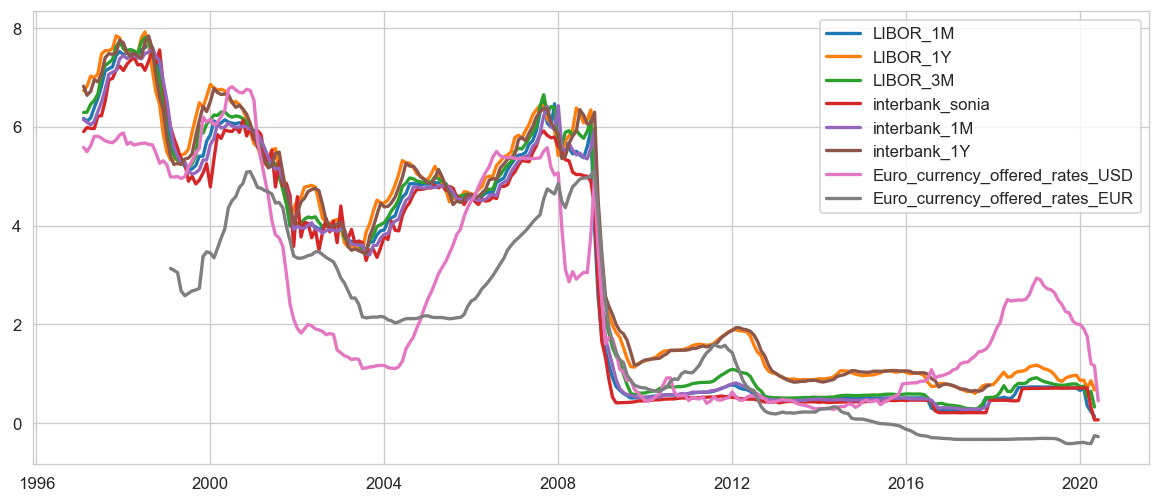

In [135]:
plt.figure(figsize=(12,5),dpi=120)
for i in range(len(items)):
    plt.plot(merged_dataset.index,merged_dataset.iloc[:,i].values,label = items[i],lw=2)
plt.legend()
plt.show()

### Pick a interested index to act as the benchmark for interest rate change

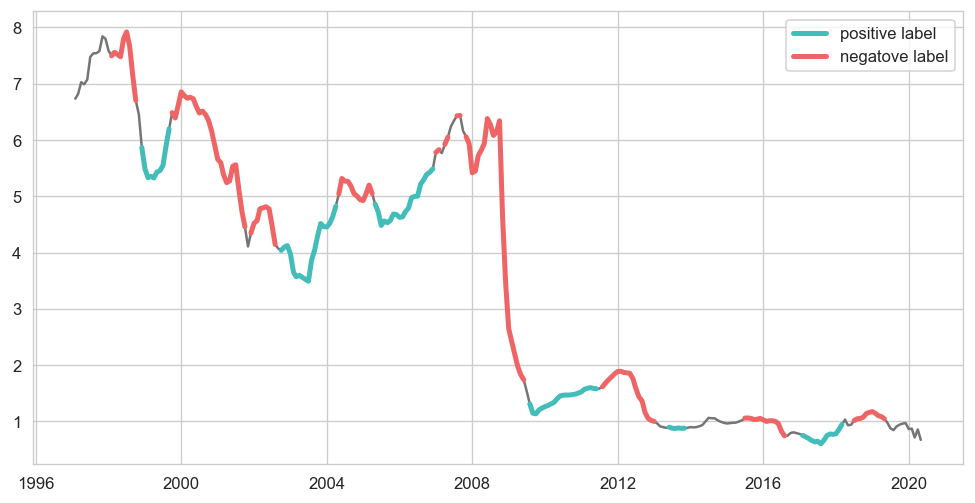

In [647]:
def create_label_for_dictionary(list_of_value,date_range):
    date_range = merged_dataset.index
    if list_of_value[-1] == np.nan:
        list_of_value[-1] = list_of_value[-2]
    plot_positive = [np.nan for i in list_of_value]
    plot_negative = [np.nan for i in list_of_value]

    rate_change = [0 for i in list_of_value]
    threshold = 0.1
    for i in range(12,len(rate_change)-12):
        if list_of_value[i]-list_of_value[i+12]>threshold:
            rate_change[i] = -1
            plot_negative[i] = list_of_value[i]
        elif list_of_value[i]-list_of_value[i+12]<-threshold:
            rate_change[i] = 1
            plot_positive[i] = list_of_value[i]
    plt.figure(figsize=(10,5),dpi=120)
    plt.plot(date_range,list_of_value,color='#757575')
    plt.plot(date_range,plot_positive,color='#42bdb9',lw=3,label='positive label')
    plt.plot(date_range,plot_negative,color='#ef6565',lw=3,label='negatove label')
    plt.legend()
    return rate_change

date_range = merged_dataset.index
list_of_value = merged_dataset.LIBOR_1Y.values
rate_change = create_label_for_dictionary(list_of_value,date_range)

# step 1: create benchmark

In [169]:
label_df = pd.DataFrame(data={'label':rate_change},index = pd.DatetimeIndex(date_range))
minutes_timeseries = MPC_minutes.loc[:,['date','title','N_topics']]
minutes_timeseries = minutes_timeseries.set_index('date')
minutes_timeseries.index = pd.DatetimeIndex(minutes_timeseries.index)+pd.offsets.MonthBegin(0)
label_list = [label_df.loc[i,'label'] for i in minutes_timeseries.index]
minutes_timeseries.loc[:,'label'] = label_list
minutes_timeseries

title  \
date                                                            
2020-06-01         Bank Rate maintained at 01% - May 2020_1st   
2020-04-01       Bank Rate maintained at 01% - March 2020_1st   
2020-04-01  Minutes of the special Monetary Policy Committ...   
2020-02-01    Bank Rate maintained at 075% - January 2020_1st   
2020-01-01   Bank Rate maintained at 075% - December 2019_1st   
...                                                       ...   
1997-12-01  Minutes of the MPC Meeting held on 8 and 9 Oct...   
1997-11-01  Minutes of the MPC Meeting held on 10 and 11 S...   
1997-10-01  Minutes of the MPC Meeting held on 6 and 7 Aug...   
1997-09-01  Minutes of the MPC Meeting held on 9 and 10 Ju...   
1997-08-01  Minutes of the MPC Meeting held on 5 and 6 Jun...   

                                                     N_topics  label  
date                                                                  
2020-06-01  [[Growth and inflation projections, Authoritie...      0  
2020-04-01  [[Growth and inflation projections, The Bank o...      0  
2020-04-01  [[Financial markets, Since the January MPC mee...      0  
2020-02-01  [[Growth and inflation projections, The Bank o...      0  
2020-01-01  [[Growth and inflation projections, The Bank o...      0  
...                                                       ...    ...  
1997-12-01  [[Financial markets, There was little new info...      0  
1997-11-01  [[Financial markets, The Committee turned its ...      0  
1997-10-01  [[Growth and inflation projections, The sterli...      0  
1997-09-01  [[Financial markets, The estimated change in n...      0  
1997-08-01  [[Financial markets, Short-term interest rates...      0  

[261 rows x 3 columns]

In [266]:
positve_rate_change = minutes_timeseries.loc[minutes_timeseries.loc[:,'label']==1,:]
negative_rate_change = minutes_timeseries.loc[minutes_timeseries.loc[:,'label']==-1,:]
neutral_rate_change = minutes_timeseries.loc[minutes_timeseries.loc[:,'label']==0,:]
print(len(positve_rate_change))
print(len(negative_rate_change))
print(len(neutral_rate_change))

89
119
53


**First look at postive change and coocurance**

In [250]:
topics =[
    'Financial markets',
    'The immediate policy decision',
    'Growth and inflation projections',
    'Money, credit, demand and output',
    'Supply, costs and prices',
    'The international economy',
    'All'
]

In [315]:
def create_word_frequency(positve_rate_change):

    all_corpus = {i:[] for i in topics}
    wordfreq = {i:{} for i in topics}

    for doc in positve_rate_change.N_topics:
        for para in doc:
            all_corpus[para[0]].append(preprocess_data(para[1:]))
            all_corpus['All'].append(preprocess_data(para[1:]))

    for i in topics:
        for corpus in all_corpus[i]:
            for sentence in corpus:
                for token in sentence:
                    if token not in wordfreq[i].keys():
                        wordfreq[i][token] = 1
                    else:
                        wordfreq[i][token] += 1
        wordfreq[i] = {k: v for k, v in sorted(wordfreq[i].items(), key=lambda item: -item[1])} # sorting
    return wordfreq


postive_word_freq = create_word_frequency(positve_rate_change)
negative_word_freq = create_word_frequency(negative_rate_change)
neutral_word_freq = create_word_frequency(neutral_rate_change)

In [261]:
# now the tfidf transformation
import math
for topic in topics:
    Num_n = sum(negative_word_freq[topic].values())
    Num_p = sum(postive_word_freq[topic].values())
    Num_ne = sum(neutral_word_freq[topic].values())
    
    word_count_df = pd.DataFrame(index = negative_word_freq[topic].keys(),data={'negative count':list(negative_word_freq[topic].values())
        }).join(
            pd.DataFrame(index=postive_word_freq[topic].keys(),data={'postive count':list(postive_word_freq[topic].values())}),
            how ='outer'
        ).join(
            pd.DataFrame(index=neutral_word_freq[topic].keys(),data={'neutral count':list(neutral_word_freq[topic].values())}),
            how ='outer'
        ).fillna(0)


    TFIDF_df = word_count_df.copy()
    TFIDF_df.loc[:,'negative count'] = TFIDF_df.loc[:,'negative count']/Num_n
    TFIDF_df.loc[:,'postive count'] = TFIDF_df.loc[:,'postive count']/Num_p
    TFIDF_df.loc[:,'neutral count'] = TFIDF_df.loc[:,'neutral count']/Num_ne

    idfDict = pd.DataFrame(index=word_count_df.index,data={'count':[0 for i in range(len(word_count_df))]})
    for doc in [negative_word_freq[topic], postive_word_freq[topic],neutral_word_freq[topic]]:
        for word, val in doc.items():
            if val > 0:
                idfDict.loc[word,'count'] += 1

    for word in idfDict.index:
        idfDict.loc[word,'count'] = math.log10(3 / float(idfDict.loc[word,'count']))

   
    word_count_df.loc[:,'negative count idf'] = TFIDF_df.loc[:,'negative count']*idfDict.loc[:,'count']
    word_count_df.loc[:,'postive count idf'] = TFIDF_df.loc[:,'postive count']*idfDict.loc[:,'count']

    multiplier = Num_p/Num_n  
    word_count_df.loc[:,'negative count'] = (word_count_df.loc[:,'negative count']*multiplier).round(0) 
    multiplier = Num_p/Num_ne
    word_count_df.loc[:,'neutral count'] = (word_count_df.loc[:,'neutral count']*multiplier).round(0) 
    
    word_count_df.loc[:,'p/n difference']    = word_count_df.loc[:,'postive count'] - word_count_df.loc[:,'negative count']
    word_count_df.loc[:,'p percentage']    = word_count_df.loc[:,'postive count'] / ( word_count_df.loc[:,'postive count']+word_count_df.loc[:,'negative count']+word_count_df.loc[:,'neutral count'])
    word_count_df.loc[:,'n percentage']    = word_count_df.loc[:,'negative count'] / ( word_count_df.loc[:,'postive count']+word_count_df.loc[:,'negative count']+word_count_df.loc[:,'neutral count'])
    word_count_df.to_csv('./Dictionary_based_method/tf_idf_data/{}.csv'.format(topic))

In [263]:
word_count_df.sort_values(by=['p percentage'], ascending=False)

negative count  postive count  neutral count  negative count idf  \
paramount               0.0            1.0            0.0            0.000000   
synthet                 0.0            1.0            0.0            0.000000   
propel                  0.0            1.0            0.0            0.000000   
unionist                0.0            1.0            0.0            0.000000   
syria                   0.0            1.0            0.0            0.000000   
...                     ...            ...            ...                 ...   
recapitalis             9.0            0.0            0.0            0.000024   
recalibr                0.0            0.0            1.0            0.000000   
recalcul                0.0            0.0            1.0            0.000000   
eba                     0.0            0.0            3.0            0.000000   
aaa                     1.0            0.0            0.0            0.000002   

             postive count idf  p/n difference  p percentage  n percentage  
paramount             0.000003             1.0           1.0           0.0  
synthet               0.000003             1.0           1.0           0.0  
propel                0.000003             1.0           1.0           0.0  
unionist              0.000003             1.0           1.0           0.0  
syria                 0.000003             1.0           1.0           0.0  
...                        ...             ...           ...           ...  
recapitalis           0.000000            -9.0           0.0           1.0  
recalibr              0.000000             0.0           0.0           0.0  
recalcul              0.000000             0.0           0.0           0.0  
eba                   0.000000             0.0           0.0           0.0  
aaa                   0.000000            -1.0           0.0           1.0  

[4379 rows x 8 columns]

#### Document Count

In [442]:
def create_doc_frequency(positve_rate_change):
    all_corpus = {i:[] for i in topics}
    wordfreq = {i:{} for i in topics}
    
    for doc in positve_rate_change.N_topics:
        document = []
        for para in doc:
            all_corpus[para[0]].append(preprocess_data(para[1:]))
            document += para[1:]
        all_corpus['All'].append(preprocess_data(document))

    for i in topics:
        for corpus in all_corpus[i]:
            seen_word = []
            for sentence in corpus:
                for token in sentence:
                    if token not in seen_word:
                        seen_word.append(token)
                        if token not in wordfreq[i].keys():
                            wordfreq[i][token] = 1
                        else:
                            wordfreq[i][token] += 1
   
    
    return wordfreq


postive_doc_freq = create_doc_frequency(positve_rate_change)
negative_doc_freq = create_doc_frequency(negative_rate_change)
neutral_doc_freq = create_doc_frequency(neutral_rate_change)

multiplier = len(positve_rate_change)/len(negative_rate_change)
multiplier_ne = len(neutral_rate_change)/len(negative_rate_change)

In [443]:
for topic in topics:
    doc_count_df = pd.DataFrame(index = negative_doc_freq[topic].keys(),data={'negative count':list(negative_doc_freq[topic].values())
        }).join(
            pd.DataFrame(index=postive_doc_freq[topic].keys(),data={'postive count':[int(i/multiplier) for i in list(postive_doc_freq[topic].values())]}),
            how ='outer'
        ).join(
            pd.DataFrame(index=neutral_doc_freq[topic].keys(),data={'neutral count':[int(i/multiplier_ne) for i in list(neutral_doc_freq[topic].values())]}),
            how ='outer'
        ).fillna(0)
    doc_count_df.loc[:,'p percentage']    = doc_count_df.loc[:,'postive count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count']+doc_count_df.loc[:,'neutral count'])
    doc_count_df.loc[:,'n percentage']    = doc_count_df.loc[:,'negative count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count']+doc_count_df.loc[:,'neutral count'])
    doc_count_df.loc[:,'p percentage no neutral']    = doc_count_df.loc[:,'postive count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count'])
    doc_count_df.loc[:,'n percentage no neutral']    = doc_count_df.loc[:,'negative count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count'])

    doc_count_df = doc_count_df.loc[(doc_count_df['negative count']+doc_count_df['postive count']+doc_count_df['neutral count'])>10,:]
    doc_count_df.to_csv('./Dictionary_based_method/doc_freq_data/{}.csv'.format(topic))
    #doc_count_df.sort_values(by=['p percentage'],ascending=False)

**Calibrate mcdonald dictionary and financial stability dictionary**

In [667]:
def load_LM_dictionary():
    LM_dict = pd.read_excel('.\Dictionary_based_method\L&M dictioanry.xls').loc[:,['Entry','Positiv','Negativ','Econ@','ECON']]
    LM_dict = LM_dict.dropna(subset = ['Econ@','ECON'])
    LM_dict.loc[:,'sentiment'] = 'Neutral'
    LM_dict.loc[LM_dict.loc[:,'Positiv']=='Positiv','sentiment'] = 'Positive'
    LM_dict.loc[LM_dict.loc[:,'Negativ']=='Negativ','sentiment'] = 'Negative'
    LM_dict.loc[:,'Entry'] =  [lemma.lemmatize(p_stemmer.stem(re.sub('#[0-9]', '',i))) for i in LM_dict.loc[:,'Entry'].apply(lambda x: x.lower()) if (i not in en_stop) and (i not in exclude)]       
    LM_dict.drop_duplicates(subset ='Entry', keep = "first", inplace = True) 
    LM_dict = LM_dict.loc[:,['Entry','sentiment']]
    return LM_dict
LM_dict = load_LM_dictionary()
LM_dict.head()

Entry sentiment
88      account   Neutral
96        accru  Positive
277       agenc   Neutral
302  agricultur   Neutral
409    aluminum   Neutral

In [464]:
def find_frequency(word,dictionary,topic):
    if word in dictionary[topic].keys():
        return dictionary[topic][word]
    else:
        return 0
    
multiplier = len(positve_rate_change)/len(negative_rate_change)  
for topic in topics:
    topic_LM_dict = LM_dict.copy()
    topic_LM_dict.loc[:,'word_count_positive'] = topic_LM_dict.loc[:,'Entry'].apply(lambda x: find_frequency(x,postive_word_freq,topic))
    topic_LM_dict.loc[:,'word_count_negative'] = (topic_LM_dict.loc[:,'Entry'].apply(lambda x: find_frequency(x,negative_word_freq,topic))*multiplier).round(0)

    topic_LM_dict.loc[:,'doc_count_positive']  = topic_LM_dict.loc[:,'Entry'].apply(lambda x: find_frequency(x,postive_doc_freq,topic))
    topic_LM_dict.loc[:,'doc_count_negative']  = (topic_LM_dict.loc[:,'Entry'].apply(lambda x: find_frequency(x,negative_doc_freq,topic))*multiplier).round(0)
   
    topic_LM_dict.loc[:,'p percentage word']     = topic_LM_dict.loc[:,'word_count_positive'] / ( topic_LM_dict.loc[:,'word_count_positive']+topic_LM_dict.loc[:,'word_count_negative'])
    topic_LM_dict.loc[:,'n percentage word']     = topic_LM_dict.loc[:,'word_count_negative'] / ( topic_LM_dict.loc[:,'word_count_positive']+topic_LM_dict.loc[:,'word_count_negative'])
    topic_LM_dict.loc[:,'p percentage document'] = topic_LM_dict.loc[:,'doc_count_positive']  / ( topic_LM_dict.loc[:,'doc_count_positive'] +topic_LM_dict.loc[:,'doc_count_negative'])
    topic_LM_dict.loc[:,'n percentage document'] = topic_LM_dict.loc[:,'doc_count_negative']  / ( topic_LM_dict.loc[:,'doc_count_positive'] +topic_LM_dict.loc[:,'doc_count_negative'])

    topic_LM_dict = topic_LM_dict.loc[(topic_LM_dict['doc_count_positive']+topic_LM_dict['doc_count_negative'])>10,:]
    topic_LM_dict.to_csv('./Dictionary_based_method/LM_dictionary/{}.csv'.format(topic))
    #doc_count_df.sort_values(by=['p percentage'],ascending=False)

In [470]:
topic_LM_dict.loc[:,'word_count_positive'] / ( topic_LM_dict.loc[:,'word_count_positive'] + topic_LM_dict.loc[:,'word_count_negative'])

88       0.489796
277      0.583333
302      0.285714
725      0.453125
921      0.412729
           ...   
11169    0.385714
11340    0.489985
11556    0.403509
11673    0.494382
11757    0.569873
Length: 118, dtype: float64

**Same algorithm for financial stability dictionary**

In [371]:
def load_FS_dictionary():
    FS_dict = pd.read_excel('./Dictionary_based_method/Stability_dictionary.xlsx')
    FS_dict.loc[FS_dict.loc[:,'Positive']==1,'sentiment'] = 'Positive'
    FS_dict.loc[FS_dict.loc[:,'Negative']==1,'sentiment'] = 'Negative'
    FS_dict.loc[:,'Entry'] =  [lemma.lemmatize(p_stemmer.stem(re.sub('#[0-9]', '',i))) for i in FS_dict.loc[:,'Word'].apply(lambda x: x.lower()) if (i not in en_stop) and (i not in exclude)]    
    FS_dict = FS_dict.loc[:,['Entry','sentiment']]
    FS_dict.drop_duplicates(subset ='Entry', keep = "first", inplace = True)
    return FS_dict

FS_dict = load_FS_dictionary()

for topic in topics:
    topic_FS_dict = FS_dict.copy()
    topic_FS_dict.loc[:,'word_count_positive'] = topic_FS_dict.loc[:,'Entry'].apply(lambda x: find_frequency(x,postive_word_freq,topic))
    topic_FS_dict.loc[:,'word_count_negative'] = (topic_FS_dict.loc[:,'Entry'].apply(lambda x: find_frequency(x,negative_word_freq,topic))*multiplier).round(0)

    topic_FS_dict.loc[:,'doc_count_positive']  = topic_FS_dict.loc[:,'Entry'].apply(lambda x: find_frequency(x,postive_doc_freq,topic))
    topic_FS_dict.loc[:,'doc_count_negative']  = (topic_FS_dict.loc[:,'Entry'].apply(lambda x: find_frequency(x,negative_doc_freq,topic))*multiplier).round(0)
   
    topic_FS_dict.loc[:,'p percentage word']     = topic_FS_dict.loc[:,'word_count_positive'] / ( topic_FS_dict.loc[:,'word_count_positive']+topic_FS_dict.loc[:,'word_count_negative'])
    topic_FS_dict.loc[:,'n percentage word']     = topic_FS_dict.loc[:,'word_count_negative'] / ( topic_FS_dict.loc[:,'word_count_positive']+topic_FS_dict.loc[:,'word_count_negative'])
    topic_FS_dict.loc[:,'p percentage document'] = topic_FS_dict.loc[:,'doc_count_positive']  / ( topic_FS_dict.loc[:,'doc_count_positive'] +topic_FS_dict.loc[:,'doc_count_negative'])
    topic_FS_dict.loc[:,'n percentage document'] = topic_FS_dict.loc[:,'doc_count_negative']  / ( topic_FS_dict.loc[:,'doc_count_positive'] +topic_FS_dict.loc[:,'doc_count_negative'])

    topic_FS_dict = topic_FS_dict.loc[(topic_FS_dict['doc_count_positive']+topic_FS_dict['doc_count_negative'])>10,:]
    topic_FS_dict.to_csv('./Dictionary_based_method/FS_dictionary/{}.csv'.format(topic))
    #doc_count_df.sort_values(by=['p percentage'],ascending=False)

## Method performance analysis without topic model
**Have a look how sentiment looks with LM and FS dictionary**

In [411]:
def sentiment_calculator(dictionary,doc_list):
    document = ''
    for para in doc_list:      
        document += ' '.join(para[1:])
    tokens = tokenizer.tokenize(document.lower())
    stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in tokens if (i not in en_stop) and (i not in exclude)]
    Positive_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Positive',:].copy()
    Positive_df.loc[:,'Count'] = Positive_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
    Negative_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Negative',:].copy()
    Negative_df.loc[:,'Count'] = Negative_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
    try:
        return (sum(Positive_df.Count)-sum(Negative_df.Count))/(sum(Positive_df.Count)+sum(Negative_df.Count))
    except:
        return np.nan


In [476]:
dictionary_sentiment = minutes_timeseries.copy()
dictionary_sentiment.loc[:,'FS_sentiment'] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator(FS_dict,x))
dictionary_sentiment.loc[:,'LM_sentiment'] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator(LM_dict,x))

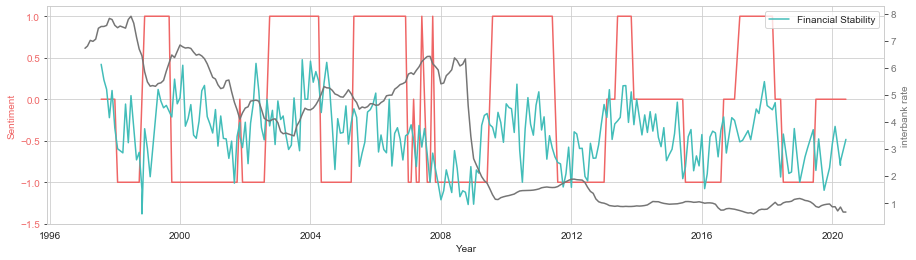

In [572]:
fig, ax1 = plt.subplots(figsize=(15,4))
ax1.set_xlabel('Year')
ax1.set_ylabel('Sentiment', color='#ef6565')
ax1.plot(dictionary_sentiment.index,dictionary_sentiment.label.values,color='#ef6565')
ax1.plot(dictionary_sentiment.index,dictionary_sentiment.FS_sentiment.values*2,color = '#42bdb9',label = 'Financial Stability')
#ax1.plot(dictionary_sentiment.index,dictionary_sentiment.LM_sentiment.values,color = '#627c9c',label = 'Mcdonald')
ax1.tick_params(axis='y', labelcolor='#ef6565')
ax1.legend(loc='upper right')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.grid(False)
ax2.set_ylabel('interbank rate', color='#757575')  # we already handled the x-label with ax1
ax2.plot(date_range,list_of_value,color='#757575')
ax2.tick_params(axis='y', labelcolor='#757575')
plt.show()

**Now build sentiment from word we select**

In [480]:
topic = 'All'
sentiment = []
word_list_all = pd.read_csv('./Dictionary_based_method/doc_freq_data/{}.csv'.format(topic),index_col=0)
word_list_all = word_list_all.loc[(word_list_all['postive count']+word_list_all['negative count'])>20,:]
positive = word_list_all.loc[word_list_all['p percentage no neutral']>0.55,:].index
sentiment += ['Positive' for i in positive]
negative = word_list_all.loc[word_list_all['n percentage no neutral']>0.6,:].index
sentiment += ['Negative' for i in negative]
Entry = list(positive)+list(negative)
New_dictionary = pd.DataFrame(data={'Entry':Entry,'sentiment':sentiment})
dictionary_sentiment.loc[:,'custome_sentiment'] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator(New_dictionary,x))
#word_list_all.sort_values(by=['p percentage no neutral'],ascending=False)

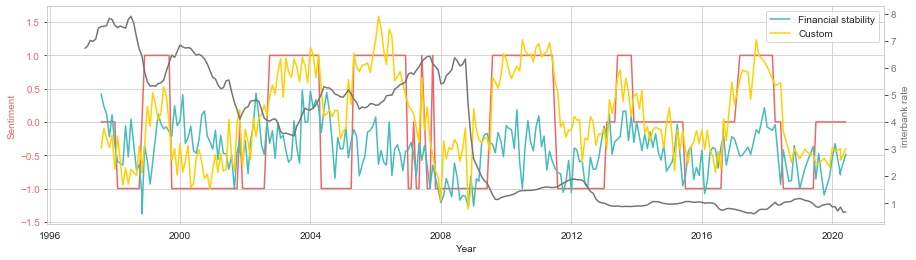

In [481]:
fig, ax1 = plt.subplots(figsize=(15,4))
ax1.set_xlabel('Year')
ax1.set_ylabel('Sentiment', color='#ef6565')
#ax1.plot(dictionary_sentiment.index,dictionary_sentiment.label.values,color='#ef6565')
ax1.plot(dictionary_sentiment.index,dictionary_sentiment.label.values,color='#ef6565')
ax1.plot(dictionary_sentiment.index,dictionary_sentiment.FS_sentiment.values*2,color = '#42bdb9',label='Financial stability')
ax1.plot(dictionary_sentiment.index,dictionary_sentiment.custome_sentiment.values*2,color = '#ffd000',label='Custom')
ax1.tick_params(axis='y', labelcolor='#ef6565')
ax1.legend(loc='upper right')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.grid(False)
ax2.set_ylabel('interbank rate', color='#757575')  # we already handled the x-label with ax1
ax2.plot(date_range,list_of_value,color='#757575')
ax2.tick_params(axis='y', labelcolor='#757575')


plt.show()

In [597]:
df1 = dictionary_sentiment.loc[:,['FS_sentiment','LM_sentiment','custome_sentiment']]
df1 = df1.groupby(df1.index).mean()
df1 = df1.reindex(pd.date_range(start = '1997-02-25', end ='2020-01-28'))
df1 = df1.ewm(halflife=60).mean()
df1.index = df1.index+pd.offsets.MonthBegin(0)
df1 = df1.groupby(df1.index).mean()

df1 =  df1.join(pd.DataFrame(data={'Interest_rate':list_of_value},index = date_range),how = 'inner')
y = list_of_value[1:] - list_of_value[:-1]
df1 =  df1.join(pd.DataFrame(data={'change_of_rate':y},index = date_range[:-1]),how = 'inner')
df1.corr()


FS_sentiment  LM_sentiment  custome_sentiment  \
FS_sentiment           1.000000      0.361575           0.338065   
LM_sentiment           0.361575      1.000000           0.026696   
custome_sentiment      0.338065      0.026696           1.000000   
Interest_rate          0.243744      0.613871          -0.203890   
change_of_rate         0.218378     -0.001894           0.320760   

                   Interest_rate  change_of_rate  
FS_sentiment            0.243744        0.218378  
LM_sentiment            0.613871       -0.001894  
custome_sentiment      -0.203890        0.320760  
Interest_rate           1.000000       -0.059070  
change_of_rate         -0.059070        1.000000

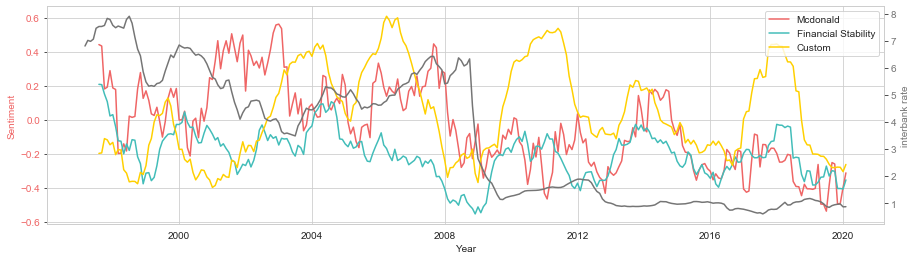

In [601]:
fig, ax1 = plt.subplots(figsize=(15,4))
ax1.set_xlabel('Year')
ax1.set_ylabel('Sentiment', color='#ef6565')
ax1.plot(df1.index,df1.LM_sentiment.values,color='#ef6565',label = 'Mcdonald')
ax1.plot(df1.index,df1.FS_sentiment.values,color = '#42bdb9',label = 'Financial Stability')
ax1.plot(df1.index,df1.custome_sentiment.values,color = '#ffd000',label='Custom')
ax1.tick_params(axis='y', labelcolor='#ef6565')
ax1.legend(loc='upper right')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.grid(False)
ax2.set_ylabel('interbank rate', color='#757575')  # we already handled the x-label with ax1
ax2.plot(df1.index,df1.Interest_rate.values,color='#757575')
ax2.tick_params(axis='y', labelcolor='#757575')
plt.show()

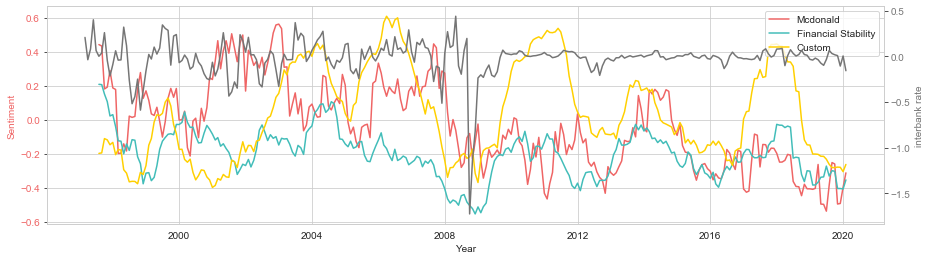

In [602]:
fig, ax1 = plt.subplots(figsize=(15,4))
ax1.set_xlabel('Year')
ax1.set_ylabel('Sentiment', color='#ef6565')
ax1.plot(df1.index,df1.LM_sentiment.values,color='#ef6565',label = 'Mcdonald')
ax1.plot(df1.index,df1.FS_sentiment.values,color = '#42bdb9',label = 'Financial Stability')
ax1.plot(df1.index,df1.custome_sentiment.values,color = '#ffd000',label='Custom')
ax1.tick_params(axis='y', labelcolor='#ef6565')
ax1.legend(loc='upper right')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.grid(False)
ax2.set_ylabel('interbank rate', color='#757575')  # we already handled the x-label with ax1
ax2.plot(df1.index,df1.change_of_rate.values,color='#757575')
ax2.tick_params(axis='y', labelcolor='#757575')
plt.show()

### now including speech data

In [483]:
def load_up_from_cleaned_speech():
    MPC_speech = pd.read_excel('./scripter/cleaned_dataset/MPC_speech.xlsx')
    file_list = os.listdir("./scripter/cleaned_dataset/Speech_MPC")
    for n,file in enumerate(file_list):
        text_file = open("./scripter/cleaned_dataset/Speech_MPC/{}".format(file), "r").read()
        MPC_speech.loc[MPC_speech['title']==file[:-4],'document_string'] = text_file
    return MPC_speech
MPC_speech = load_up_from_cleaned_speech()

In [840]:
def sentiment_calculator_speech(dictionary,doc_list):
    document = ''
    for para in doc_list:      
        document += para+' '
    tokens = tokenizer.tokenize(document.lower())
    stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in tokens if (i not in en_stop) and (i not in exclude)]
    Positive_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Positive',:].copy()
    Positive_df.loc[:,'Count'] = Positive_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
    Negative_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Negative',:].copy()
    Negative_df.loc[:,'Count'] = Negative_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
    try:
        return (sum(Positive_df.Count)-sum(Negative_df.Count))/(sum(Positive_df.Count)+sum(Negative_df.Count))
    except:
        return np.nan
    


In [501]:
MPC_speech.loc[:,'N_topics'] = MPC_speech.loc[:,'document_string'].apply(lambda x: str(x).split(' ###newline### '))
speech_timeseries = MPC_speech.loc[:,['title','date','N_topics']]
speech_timeseries.loc[:,'FS_sentiment'] = speech_timeseries.loc[:,'N_topics'].apply(lambda x: sentiment_calculator_speech(FS_dict,x))
speech_timeseries.loc[:,'LM_sentiment'] = speech_timeseries.loc[:,'N_topics'].apply(lambda x: sentiment_calculator_speech(LM_dict,x))
speech_timeseries.loc[:,'custome_sentiment'] = speech_timeseries.loc[:,'N_topics'].apply(lambda x: sentiment_calculator_speech(New_dictionary,x))
speech_timeseries = speech_timeseries.set_index('date')

In [507]:
speech_timeseries.index = pd.DatetimeIndex(speech_timeseries.index)
speech_timeseries

title  \
date                                                            
2020-05-28  Covid-19 and monetary policy - speech by Micha...   
2020-04-23  Monetary policy and the Bank of England’s bala...   
2020-04-16  Monetary policy during pandemics inflation bef...   
2020-03-05  The grand unifying theory (and practice) of ma...   
2020-03-04  Inflation and beliefs about inflation - speech...   
...                                                       ...   
1998-01-14  The Chemical Industries Association Business O...   
1997-11-18  Developments in UK financial markets - speech ...   
1997-06-24  The Sixteenth Mais Lecture - speech by Edward ...   
1997-06-12      Lord Mayors Banquet - speech by Edward George   
1997-02-25  Speech by Edward George for the 3rd Euromoney ...   

                                                     N_topics  FS_sentiment  \
date                                                                          
2020-05-28  [ The views expressed here are not necessarily...     -0.329412   
2020-04-23  [ I would like to thank Rodrigo Guimaraes, Len...     -0.191011   
2020-04-16  [ The views are not necessarily those of the B...      0.106145   
2020-03-05  [ I would like to thank Daisy McGregor, Nicola...      0.060703   
2020-03-04  [ I ve received helpful comments from colleagu...     -0.395349   
...                                                       ...           ...   
1998-01-14  [I am particularly pleased to be associated wi...     -0.057143   
1997-11-18  [ Perhaps the single most momentous change in ...      0.791667   
1997-06-24  [I was delighted to have been invited to deliv...      0.371429   
1997-06-12  [Let me begin by congratulating you, Chancello...      0.125000   
1997-02-25  [Thank you, Mr Chairman, for that kind introdu...      0.098039   

            LM_sentiment  custome_sentiment  
date                                         
2020-05-28     -0.142857          -0.101796  
2020-04-23     -0.363636          -0.191111  
2020-04-16     -0.846154           0.025126  
2020-03-05     -0.134328          -0.188406  
2020-03-04     -0.333333          -0.266667  
...                  ...                ...  
1998-01-14      1.000000          -0.222222  
1997-11-18      0.565217          -0.264865  
1997-06-24      0.200000          -0.214286  
1997-06-12     -1.000000          -0.113636  
1997-02-25     -0.500000          -0.076923  

[783 rows x 5 columns]

No handles with labels found to put in legend.


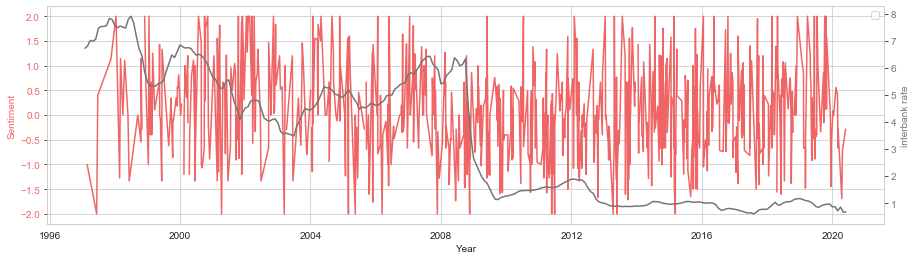

In [518]:
list(speech_timeseries.LM_sentiment.values*2).ewm(halflife=30).mean()
fig, ax1 = plt.subplots(figsize=(15,4))

ax1.set_xlabel('Year')
ax1.set_ylabel('Sentiment', color='#ef6565')
#ax1.plot(dictionary_sentiment.index,dictionary_sentiment.label.values,color='#ef6565')
ax1.plot(speech_timeseries.index,,color='#ef6565')
#ax1.plot(speech_timeseries.index,speech_timeseries.FS_sentiment.values*2,color = '#42bdb9',label='Financial stability')
#ax1.plot(speech_timeseries.index,speech_timeseries.custome_sentiment.values*2,color = '#ffd000',label='Custom')
ax1.tick_params(axis='y', labelcolor='#ef6565')
ax1.legend(loc='upper right')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.grid(False)
ax2.set_ylabel('interbank rate', color='#757575')  # we already handled the x-label with ax1
ax2.plot(date_range,list_of_value,color='#757575')
ax2.tick_params(axis='y', labelcolor='#757575')


plt.show()

In [673]:
df1 = speech_timeseries.loc[:,['FS_sentiment','LM_sentiment','custome_sentiment']]
df1 = df1.groupby(df1.index).mean()
df1 = df1.reindex(pd.date_range(start = '1997-02-25', end ='2020-01-28'))
df1 = df1.ewm(halflife=60).mean()
df1.index = df1.index+pd.offsets.MonthBegin(0)
df1 = df1.groupby(df1.index).mean()
df1 =  df1.join(pd.DataFrame(data={'Interest_rate':list_of_value},index = date_range),how = 'inner')
y = list_of_value[1:] - list_of_value[:-1]
df1 =  df1.join(pd.DataFrame(data={'change_of_rate':y},index = date_range[:-1]),how = 'inner')
df1.corr()





FS_sentiment  LM_sentiment  custome_sentiment  \
FS_sentiment           1.000000      0.293591          -0.160610   
LM_sentiment           0.293591      1.000000          -0.156858   
custome_sentiment     -0.160610     -0.156858           1.000000   
Interest_rate          0.211235      0.133387          -0.317046   
change_of_rate         0.167876      0.022184           0.126377   

                   Interest_rate  change_of_rate  
FS_sentiment            0.211235        0.167876  
LM_sentiment            0.133387        0.022184  
custome_sentiment      -0.317046        0.126377  
Interest_rate           1.000000       -0.059070  
change_of_rate         -0.059070        1.000000

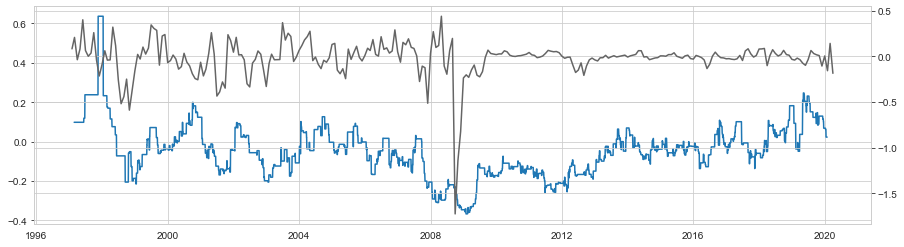

In [675]:
df1=speech_timeseries.reset_index()
df1.drop_duplicates(subset ='date', keep = "first", inplace = True)
df1=df1.set_index('date')
x= df1.FS_sentiment
x = x.reindex(pd.date_range(start = '1997-02-25', end ='2020-01-28'))
x = x.ewm(halflife=60).mean()

fig, ax1 = plt.subplots(figsize=(15,4))
ax1.plot(x.index,x.values)
ax2 = ax1.twinx()
y = list_of_value[1:] - list_of_value[:-1]
ax2.plot(date_range[:-1],y ,color='#656565')

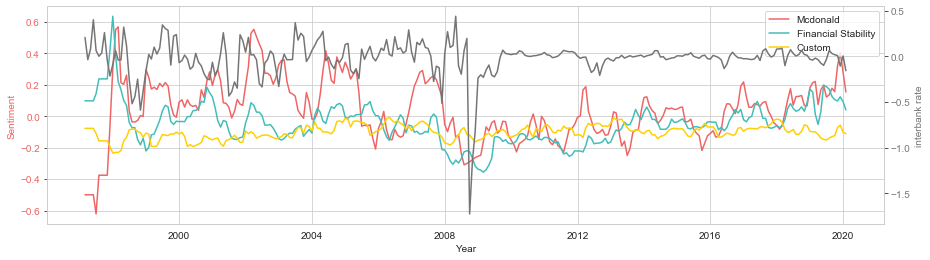

In [604]:
fig, ax1 = plt.subplots(figsize=(15,4))
ax1.set_xlabel('Year')
ax1.set_ylabel('Sentiment', color='#ef6565')
ax1.plot(df1.index,df1.LM_sentiment.values,color='#ef6565',label = 'Mcdonald')
ax1.plot(df1.index,df1.FS_sentiment.values,color = '#42bdb9',label = 'Financial Stability')
ax1.plot(df1.index,df1.custome_sentiment.values,color = '#ffd000',label='Custom')
ax1.tick_params(axis='y', labelcolor='#ef6565')
ax1.legend(loc='upper right')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.grid(False)
ax2.set_ylabel('interbank rate', color='#757575')  # we already handled the x-label with ax1
ax2.plot(df1.index,df1.change_of_rate.values,color='#757575')
ax2.tick_params(axis='y', labelcolor='#757575')
plt.show()

# Step 2: create topical dictionary sentiments

In [668]:
def load_interest_rate():
    data_list = []
    for i in ['LIBOR_1M.csv','LIBOR_1Y.csv','LIBOR_3M.csv']:
        df = pd.read_csv('./scripter/cleaned_dataset/{}'.format(i),index_col = 0)
        df.columns = [i[:-4]]
        data_list.append(df)
    libor_rate = pd.concat(data_list,axis=1).dropna()
    for i in range(3):
        libor_rate.iloc[:,i] = libor_rate.iloc[:,i].astype(float).round(4)
        
    data_list = []
    for i in ['interbank_sonia.csv','interbank_1M.csv','interbank_1Y.csv','Euro_currency_offered_rates_USD.csv','Euro_currency_offered_rates_EUR.csv']:
        df = pd.read_csv('./scripter/cleaned_dataset/{}'.format(i),index_col = 0)
        df.index = pd.DatetimeIndex(df.index)+pd.offsets.MonthBegin(0)
        df.columns = [i[:-4]]
        data_list.append(df)
    sonia_rate = data_list[0].join(data_list[1]).join(data_list[2]).join(data_list[3]).join(data_list[4])
    merged_dataset = libor_rate.join(sonia_rate,how='outer')
    items = list(merged_dataset)
    merged_dataset = merged_dataset.loc[merged_dataset.index>'1997-01-01',:]
    return merged_dataset

def create_label_for_dictionary(list_of_value,date_range):
    date_range = merged_dataset.index
    if list_of_value[-1] == np.nan:
        list_of_value[-1] = list_of_value[-2]
    plot_positive = [np.nan for i in list_of_value]
    plot_negative = [np.nan for i in list_of_value]

    rate_change = [0 for i in list_of_value]
    threshold = 0.1
    for i in range(12,len(rate_change)-12):
        if list_of_value[i]-list_of_value[i+12]>threshold:
            rate_change[i] = -1
            plot_negative[i] = list_of_value[i]
        elif list_of_value[i]-list_of_value[i+12]<-threshold:
            rate_change[i] = 1
            plot_positive[i] = list_of_value[i]
    plt.figure(figsize=(10,5),dpi=120)
    plt.plot(date_range,list_of_value,color='#757575')
    plt.plot(date_range,plot_positive,color='#42bdb9',lw=3,label='positive label')
    plt.plot(date_range,plot_negative,color='#ef6565',lw=3,label='negatove label')
    plt.legend()
    return rate_change

In [645]:
merged_dataset = load_interest_rate()

base_rate = pd.read_csv('./scripter/cleaned_dataset/Bank Rate  Bank of England Database.csv',index_col = 0)
base_rate.index = pd.DatetimeIndex(base_rate.index)
base_rate = base_rate.reindex(pd.date_range(start = base_rate.index[-1], end = merged_dataset.index[-1]))
for i in range(1,len(base_rate)):
    if base_rate.iloc[i,0]!=base_rate.iloc[i,0]:
        base_rate.iloc[i,0]=base_rate.iloc[i-1,0]
merged_dataset = merged_dataset.join(base_rate,how='inner')

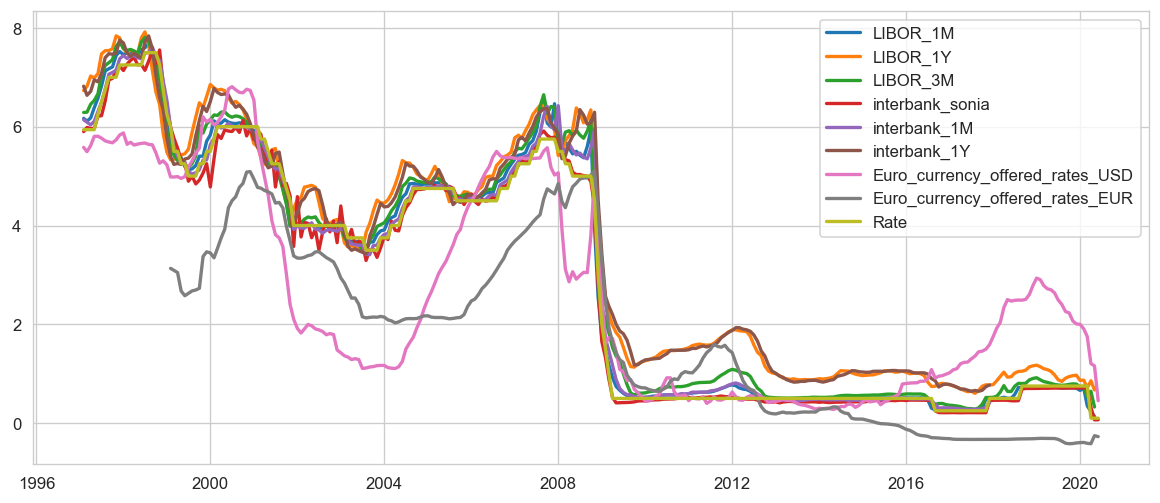

In [651]:
items = list(merged_dataset)
plt.figure(figsize=(12,5),dpi=120)
for i in range(len(items)):
    plt.plot(merged_dataset.index,merged_dataset.iloc[:,i].values,label = items[i],lw=2)
plt.legend()
plt.show()

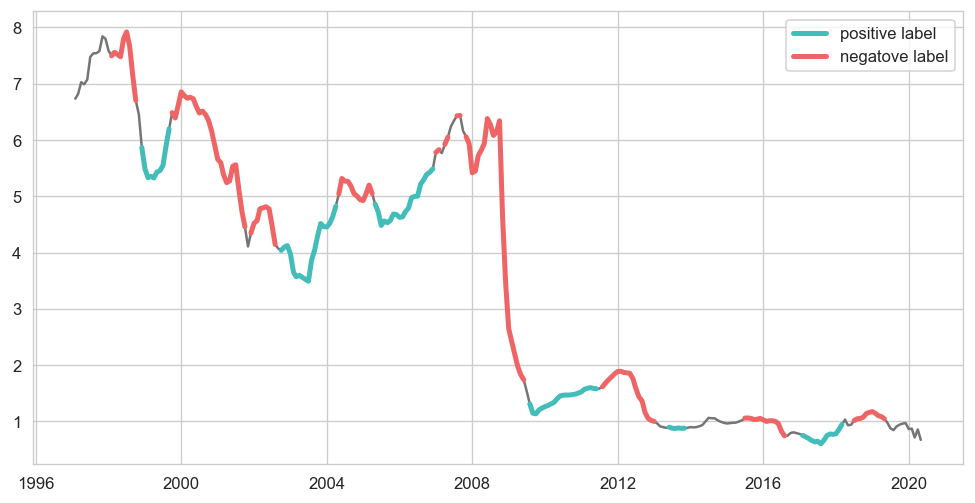

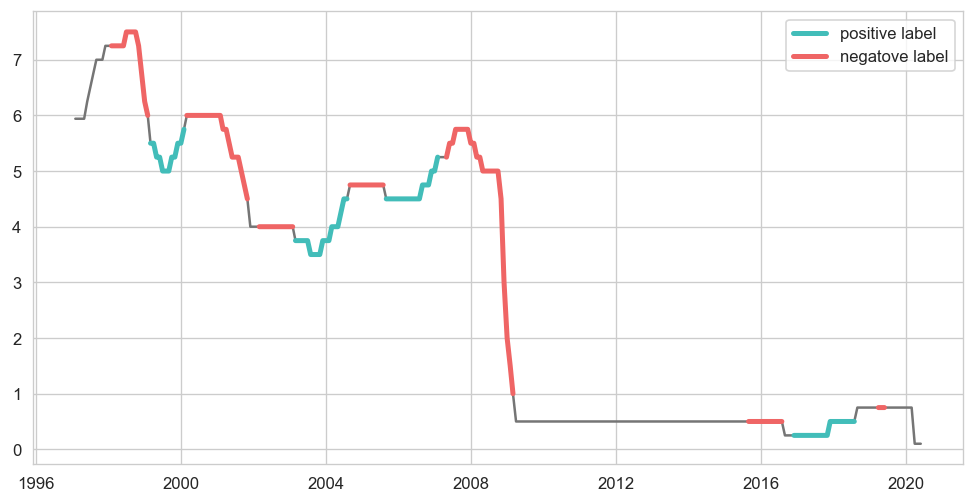

In [671]:
date_range = merged_dataset.index
list_of_value = merged_dataset.LIBOR_1Y.values
rate_change = create_label_for_dictionary(list_of_value,date_range)
date_range = merged_dataset.index
list_of_value_2 = merged_dataset.Rate.values
rate_change_2 = create_label_for_dictionary(list_of_value_2,date_range)

In [659]:
minutes_timeseries = MPC_minutes.loc[:,['date','title','N_topics']]
minutes_timeseries = minutes_timeseries.set_index('date')
minutes_timeseries.index = pd.DatetimeIndex(minutes_timeseries.index)+pd.offsets.MonthBegin(0)

label_df = pd.DataFrame(data={'label':rate_change},index = pd.DatetimeIndex(date_range))
label_list = [label_df.loc[i,'label'] for i in minutes_timeseries.index]
minutes_timeseries.loc[:,'label'] = label_list

label_df = pd.DataFrame(data={'label':rate_change_2},index = pd.DatetimeIndex(date_range))
label_list = [label_df.loc[i,'label'] for i in minutes_timeseries.index]
minutes_timeseries.loc[:,'label_2'] = label_list
minutes_timeseries.head()

title  \
date                                                            
2020-06-01         Bank Rate maintained at 01% - May 2020_1st   
2020-04-01       Bank Rate maintained at 01% - March 2020_1st   
2020-04-01  Minutes of the special Monetary Policy Committ...   
2020-02-01    Bank Rate maintained at 075% - January 2020_1st   
2020-01-01   Bank Rate maintained at 075% - December 2019_1st   

                                                     N_topics  label  label_2  
date                                                                           
2020-06-01  [[Growth and inflation projections, Authoritie...      0        0  
2020-04-01  [[Growth and inflation projections, The Bank o...      0        0  
2020-04-01  [[Financial markets, Since the January MPC mee...      0        0  
2020-02-01  [[Growth and inflation projections, The Bank o...      0        0  
2020-01-01  [[Growth and inflation projections, The Bank o...      0        0

## Step 2.1 analysis performance accross different topics

In [780]:
def create_word_frequency(positve_rate_change):

    all_corpus = {i:[] for i in topics}
    wordfreq = {i:{} for i in topics}

    for doc in positve_rate_change.N_topics:
        for para in doc:
            all_corpus[para[0]].append(preprocess_data(para[1:]))
            all_corpus['All'].append(preprocess_data(para[1:]))

    for i in topics:
        for corpus in all_corpus[i]:
            for sentence in corpus:
                for token in sentence:
                    if token not in wordfreq[i].keys():
                        wordfreq[i][token] = 1
                    else:
                        wordfreq[i][token] += 1
        wordfreq[i] = {k: v for k, v in sorted(wordfreq[i].items(), key=lambda item: -item[1])} # sorting
    return wordfreq

def create_doc_frequency(positve_rate_change):
    all_corpus = {i:[] for i in topics}
    wordfreq = {i:{} for i in topics}
    
    for doc in positve_rate_change.N_topics:
        document = []
        for para in doc:
            all_corpus[para[0]].append(preprocess_data(para[1:]))
            document += para[1:]
        all_corpus['All'].append(preprocess_data(document))

    for i in topics:
        for corpus in all_corpus[i]:
            seen_word = []
            for sentence in corpus:
                for token in sentence:
                    if token not in seen_word:
                        seen_word.append(token)
                        if token not in wordfreq[i].keys():
                            wordfreq[i][token] = 1
                        else:
                            wordfreq[i][token] += 1
    return wordfreq

def load_LM_dict():
    LM_dict = pd.read_excel('.\Dictionary_based_method\L&M dictioanry.xls').loc[:,['Entry','Positiv','Negativ','Econ@','ECON']]
    LM_dict = LM_dict.dropna(subset = ['Econ@','ECON'])
    LM_dict.loc[:,'sentiment'] = 'Neutral'
    LM_dict.loc[LM_dict.loc[:,'Positiv']=='Positiv','sentiment'] = 'Positive'
    LM_dict.loc[LM_dict.loc[:,'Negativ']=='Negativ','sentiment'] = 'Negative'
    LM_dict.loc[:,'Entry'] =  [lemma.lemmatize(p_stemmer.stem(re.sub('#[0-9]', '',i))) for i in LM_dict.loc[:,'Entry'].apply(lambda x: x.lower()) if (i not in en_stop) and (i not in exclude)]       
    LM_dict.drop_duplicates(subset ='Entry', keep = "first", inplace = True) 
    LM_dict = LM_dict.loc[:,['Entry','sentiment']]
    return LM_dict

def load_FS_dictionary():
    FS_dict = pd.read_excel('./Dictionary_based_method/Stability_dictionary.xlsx')
    FS_dict.loc[FS_dict.loc[:,'Positive']==1,'sentiment'] = 'Positive'
    FS_dict.loc[FS_dict.loc[:,'Negative']==1,'sentiment'] = 'Negative'
    FS_dict.loc[:,'Entry'] =  [lemma.lemmatize(p_stemmer.stem(re.sub('#[0-9]', '',i))) for i in FS_dict.loc[:,'Word'].apply(lambda x: x.lower()) if (i not in en_stop) and (i not in exclude)]    
    FS_dict = FS_dict.loc[:,['Entry','sentiment']]
    FS_dict.drop_duplicates(subset ='Entry', keep = "first", inplace = True)
    return FS_dict

def sentiment_calculator(dictionary,doc_list):
    document = ''
    for para in doc_list:      
        document += ' '.join(para[1:])
    tokens = tokenizer.tokenize(document.lower())
    stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in tokens if (i not in en_stop) and (i not in exclude)]
    Positive_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Positive',:].copy()
    Positive_df.loc[:,'Count'] = Positive_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
    Negative_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Negative',:].copy()
    Negative_df.loc[:,'Count'] = Negative_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
    try:
        return (sum(Positive_df.Count)-sum(Negative_df.Count))/(sum(Positive_df.Count)+sum(Negative_df.Count))
    except:
        return np.nan

def find_frequency(word,dictionary,topic):
    if word in dictionary[topic].keys():
        return dictionary[topic][word]
    else:
        return 0


my_color = ['#ef6565','#42bdb9','#ffd000']
topics =[
    'Financial markets',
    'The immediate policy decision',
    'Growth and inflation projections',
    'Money, credit, demand and output',
    'Supply, costs and prices',
    'The international economy',
    'All'
]


def create_custom_dictionary(word_list,topic,para=[20,0.55,0.6]):
    sentiment = []
    word_list_all = word_list[topic]
    word_list_all = word_list_all.loc[(word_list_all['postive count']+word_list_all['negative count'])>para[0],:]
    positive = word_list_all.loc[word_list_all['p percentage no neutral']>para[1],:].index
    sentiment += ['Positive' for i in positive]
    negative = word_list_all.loc[word_list_all['n percentage no neutral']>para[2],:].index
    sentiment += ['Negative' for i in negative]
    Entry = list(positive)+list(negative)
    New_dictionary = pd.DataFrame(data={'Entry':Entry,'sentiment':sentiment})
    return New_dictionary


def create_cooccurence_list(minutes_timeseries,label='label'):
    positve_rate_change = minutes_timeseries.loc[minutes_timeseries.loc[:,label]==1,:]
    negative_rate_change = minutes_timeseries.loc[minutes_timeseries.loc[:,label]==-1,:]
    neutral_rate_change = minutes_timeseries.loc[minutes_timeseries.loc[:,label]==0,:]
    print('Positive count:{}   Negative count:{}   Neutral count:{}'.format(len(positve_rate_change),len(negative_rate_change),len(neutral_rate_change)))
    print('calculate word frequency')
    postive_doc_freq = create_doc_frequency(positve_rate_change)
    negative_doc_freq = create_doc_frequency(negative_rate_change)
    neutral_doc_freq = create_doc_frequency(neutral_rate_change)

    multiplier = len(positve_rate_change)/len(negative_rate_change)
    multiplier_ne = len(neutral_rate_change)/len(negative_rate_change)
    result = {}
    for topic in topics:
        print('create dictionary for topic: '+topic)
        doc_count_df = pd.DataFrame(index = negative_doc_freq[topic].keys(),data={'negative count':list(negative_doc_freq[topic].values())
            }).join(
                pd.DataFrame(index=postive_doc_freq[topic].keys(),data={'postive count':[int(i/multiplier) for i in list(postive_doc_freq[topic].values())]}),
                how ='outer'
            ).join(
                pd.DataFrame(index=neutral_doc_freq[topic].keys(),data={'neutral count':[int(i/multiplier_ne) for i in list(neutral_doc_freq[topic].values())]}),
                how ='outer'
            ).fillna(0)
        doc_count_df.loc[:,'p percentage']    = doc_count_df.loc[:,'postive count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count']+doc_count_df.loc[:,'neutral count'])
        doc_count_df.loc[:,'n percentage']    = doc_count_df.loc[:,'negative count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count']+doc_count_df.loc[:,'neutral count'])
        doc_count_df.loc[:,'p percentage no neutral']    = doc_count_df.loc[:,'postive count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count'])
        doc_count_df.loc[:,'n percentage no neutral']    = doc_count_df.loc[:,'negative count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count'])

        doc_count_df = doc_count_df.loc[(doc_count_df['negative count']+doc_count_df['postive count']+doc_count_df['neutral count'])>10,:]
        result[topic] = doc_count_df
    return result

def sentiment_calculator_topic(dictionary,doc_list,topic):
    document = ''
    for para in doc_list: 
        if para[0] == topic:
            document += ' '.join(para[1:])
    if document!='':
        tokens = tokenizer.tokenize(document.lower())
        stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in tokens if (i not in en_stop) and (i not in exclude)]
        Positive_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Positive',:].copy()
        Positive_df.loc[:,'Count'] = Positive_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
        Negative_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Negative',:].copy()
        Negative_df.loc[:,'Count'] = Negative_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
        try:
            return (sum(Positive_df.Count)-sum(Negative_df.Count))/(sum(Positive_df.Count)+sum(Negative_df.Count))
        except:
            return np.nan
    else:
        return np.nan
    
def create_comparison_plot(df1,column,rate = 'Interest_rate'):
    fig, ax1 = plt.subplots(figsize=(15,4))
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Sentiment', color=my_color[0])
    ax1.plot(df1.index,df1.loc[:,column].values,color = my_color[0],label = column)
    ax1.plot(df1.index,df1.label_2.values,color = my_color[1],label = 'Targeted sentiment index')
    ax1.tick_params(axis='y', labelcolor=my_color[0])
    ax1.legend(loc='upper right')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.grid(False)
    ax2.set_ylabel('interbank rate', color='#757575')  # we already handled the x-label with ax1
    ax2.plot(df1.index,df1.loc[:,rate].values,color='#757575')
    ax2.tick_params(axis='y', labelcolor='#757575')
    plt.show()
    return None   


def training_dictionary_sentiment(minutes_timeseries,para_set=[[20,0.55,0.6],[10,0.55,0.6]]):
    # approximate 3 mins
    word_list_libor    = create_cooccurence_list(minutes_timeseries,'label')
    word_list_baserate = create_cooccurence_list(minutes_timeseries,'label_2')
    custome_base_all  = create_custom_dictionary(word_list_baserate,'All',para=para_set[0])
    custome_libor_all = create_custom_dictionary(word_list_libor,'All',para=para_set[0])
    custome_base_topic  = {}
    custome_libor_topic = {}
    for topic in topics:
        custome_base_topic[topic]  = create_custom_dictionary(word_list_baserate,topic,para=para_set[1])
        custome_libor_topic[topic] = create_custom_dictionary(word_list_libor,topic,para=para_set[1])
    return (word_list_libor,word_list_baserate),(custome_base_all,custome_libor_all,custome_base_topic,custome_libor_topic)

def result_dictionary_sentiment(dictionary_model_2020,interested_topics):
    MPC_minutes = pd.read_hdf('data.h5', 'minutes')
    dictionary_sentiment = minutes_timeseries.copy()
    print('calculating all')
    dictionary_sentiment.loc[:,'base_all_sentiment'] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator(dictionary_model_2020[0],x))
    dictionary_sentiment.loc[:,'libor_all_sentiment'] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator(dictionary_model_2020[1],x))
    for topic in interested_topics:
        print('calculating topic: {}'.format(topic))
        dictionary_sentiment.loc[:,'base_{}_sentiment'.format(topic)] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator_topic(dictionary_model_2020[2][topic],x,topic))
        dictionary_sentiment.loc[:,'libor_{}_sentiment'.format(topic)] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator_topic(dictionary_model_2020[3][topic],x,topic))
    dictionary_sentiment.loc[:,'Topical_mean_base'] = dictionary_sentiment.loc[:,['base_{}_sentiment'.format(topic) for topic in interested_topics]].mean(axis=1)
    dictionary_sentiment.loc[:,'Topical_mean_libor'] = dictionary_sentiment.loc[:,['libor_{}_sentiment'.format(topic) for topic in interested_topics]].mean(axis=1)
    FS_dict = load_FS_dictionary()
    LM_dict = load_LM_dictionary()
    print('calculating dictionary sentiment')
    dictionary_sentiment.loc[:,'FS_sentiment'] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator(FS_dict,x))
    dictionary_sentiment.loc[:,'LM_sentiment'] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator(LM_dict,x))
    df1 = dictionary_sentiment.iloc[:,2:]
    df1 = df1.groupby(df1.index).mean()
    df1 = df1.reindex(pd.date_range(start = '1997-02-25', end ='2020-01-28'))
    df1 = df1.ewm(halflife=60).mean()
    df1.index = df1.index+pd.offsets.MonthBegin(0)
    df1 = df1.groupby(df1.index).mean()
    df1 =  df1.join(pd.DataFrame(data={'Interest_rate':list_of_value_2},index = date_range),how = 'inner')
    y = list_of_value_2[1:] - list_of_value_2[:-1]
    df1 =  df1.join(pd.DataFrame(data={'change_of_rate':y},index = date_range[:-1]),how = 'inner')
    return df1

In [731]:
word_document_frequency_97_20,dictionary_model_97_20 = training_dictionary_sentiment(minutes_timeseries)

Positive count:89   Negative count:118   Neutral count:54
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
Positive count:62   Negative count:95   Neutral count:104
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All


In [ ]:
# approximate 3 mins
df1 = result_dictionary_sentiment(dictionary_model_97_20,topics[:-1])

In [744]:
df1.corr().iloc[[0,1,18,19],:]

calculating all
calculating topic: Financial markets
calculating topic: The immediate policy decision
calculating topic: Growth and inflation projections
calculating topic: Money, credit, demand and output
calculating topic: Supply, costs and prices
calculating topic: The international economy


label   label_2  base_all_sentiment  libor_all_sentiment  \
label         1.000000  0.638712            0.526128             0.835730   
label_2       0.638712  1.000000            0.774565             0.638430   
FS_sentiment  0.399016  0.399228            0.216902             0.305554   
LM_sentiment  0.066243 -0.139119           -0.311791            -0.000088   

              base_Financial markets_sentiment  \
label                                 0.475584   
label_2                               0.716074   
FS_sentiment                          0.135315   
LM_sentiment                         -0.352743   

              libor_Financial markets_sentiment  \
label                                  0.715491   
label_2                                0.608765   
FS_sentiment                           0.278971   
LM_sentiment                          -0.094765   

              base_The immediate policy decision_sentiment  \
label                                             0.524201   
label_2                                           0.814741   
FS_sentiment                                      0.324750   
LM_sentiment                                     -0.263024   

              libor_The immediate policy decision_sentiment  \
label                                              0.848583   
label_2                                            0.648475   
FS_sentiment                                       0.275124   
LM_sentiment                                      -0.127870   

              base_Growth and inflation projections_sentiment  \
label                                                0.449497   
label_2                                              0.681238   
FS_sentiment                                         0.396918   
LM_sentiment                                        -0.107673   

              libor_Growth and inflation projections_sentiment  ...  \
label                                                 0.759994  ...   
label_2                                               0.462921  ...   
FS_sentiment                                          0.336150  ...   
LM_sentiment                                          0.244211  ...   

              base_Supply, costs and prices_sentiment  \
label                                        0.533711   
label_2                                      0.845495   
FS_sentiment                                 0.264877   
LM_sentiment                                -0.247155   

              libor_Supply, costs and prices_sentiment  \
label                                         0.787751   
label_2                                       0.557249   
FS_sentiment                                  0.283083   
LM_sentiment                                 -0.071237   

              base_The international economy_sentiment  \
label                                         0.549679   
label_2                                       0.784979   
FS_sentiment                                  0.187006   
LM_sentiment                                 -0.324625   

              libor_The international economy_sentiment  Topical_mean_base  \
label                                          0.810249           0.566845   
label_2                                        0.564049           0.847375   
FS_sentiment                                   0.382423           0.326497   
LM_sentiment                                   0.107497          -0.180274   

              Topical_mean_libor  FS_sentiment  LM_sentiment  Interest_rate  \
label                   0.875118      0.399016      0.066243      -0.137836   
label_2                 0.635108      0.399228     -0.139119      -0.202106   
FS_sentiment            0.329339      1.000000      0.361575       0.245016   
LM_sentiment            0.006972      0.361575      1.000000       0.641400   

              change_of_rate  
label               0.242726  
label_2             0.419701  
FS_sentiment        0.408340  
LM_sentiment       -0.027290  

[4 r

In [745]:
# combine sentiments by correlation
print(df1.corr().loc['label_2',['base_{}_sentiment'.format(topic) for topic in topics[:-1]]])
print(df1.corr().loc['label',['libor_{}_sentiment'.format(topic) for topic in topics[:-1]]])

base_Financial markets_sentiment                   0.716074
base_The immediate policy decision_sentiment       0.814741
base_Growth and inflation projections_sentiment    0.681238
base_Money, credit, demand and output_sentiment    0.848021
base_Supply, costs and prices_sentiment            0.845495
base_The international economy_sentiment           0.784979
Name: label_2, dtype: float64
libor_Financial markets_sentiment                   0.715491
libor_The immediate policy decision_sentiment       0.848583
libor_Growth and inflation projections_sentiment    0.759994
libor_Money, credit, demand and output_sentiment    0.851626
libor_Supply, costs and prices_sentiment            0.787751
libor_The international economy_sentiment           0.810249
Name: label, dtype: float64


In [ ]:
interested_topics =['The immediate policy decision','Money, credit, demand and output','Supply, costs and prices','The international economy']
sentiment_97_20 = result_dictionary_sentiment(dictionary_model_97_20,interested_topics)

In [753]:
sentiment_97_20.corr().iloc[[0,1,16,17],:]

label   label_2  base_all_sentiment  libor_all_sentiment  \
label           1.000000  0.638712            0.526128             0.835730   
label_2         0.638712  1.000000            0.774565             0.638430   
Interest_rate  -0.137836 -0.202106           -0.441605            -0.241199   
change_of_rate  0.242726  0.419701            0.406166             0.262957   

                base_The immediate policy decision_sentiment  \
label                                               0.524201   
label_2                                             0.814741   
Interest_rate                                      -0.368379   
change_of_rate                                      0.416419   

                libor_The immediate policy decision_sentiment  \
label                                                0.848583   
label_2                                              0.648475   
Interest_rate                                       -0.427181   
change_of_rate                                       0.285361   

                base_Money, credit, demand and output_sentiment  \
label                                                  0.590915   
label_2                                                0.848021   
Interest_rate                                          0.013920   
change_of_rate                                         0.338436   

                libor_Money, credit, demand and output_sentiment  \
label                                                   0.851626   
label_2                                                 0.610765   
Interest_rate                                          -0.248315   
change_of_rate                                          0.276073   

                base_Supply, costs and prices_sentiment  \
label                                          0.533711   
label_2                                        0.845495   
Interest_rate                                 -0.392171   
change_of_rate                                 0.378709   

                libor_Supply, costs and prices_sentiment  \
label                                           0.787751   
label_2                                         0.557249   
Interest_rate                                  -0.410714   
change_of_rate                                  0.261287   

                base_The international economy_sentiment  \
label                                           0.549679   
label_2                                         0.784979   
Interest_rate                                  -0.261617   
change_of_rate                                  0.371309   

                libor_The international economy_sentiment  Topical_mean_base  \
label                                            0.810249           0.584416   
label_2                                          0.564049           0.880071   
Interest_rate                                    0.030900          -0.330342   
change_of_rate                                   0.275546           0.393075   

                Topical_mean_libor  FS_sentiment  LM_sentiment  Interest_rate  \
label                     0.851234      0.399016      0.066243      -0.137836   
label_2                   0.629126      0.399228     -0.139119      -0.202106   
Interest_rate            -0.379164      0.245016      0.641400       1.000000   
change_of_rate            0.266564      0.408340     -0.027290      -0.054722   

                change_of_rate  
label                 0.242726  
label_2               0.419701  
Interest_rate        -0.054722  
change_of_rate        1.000000

**Correlation with interest rate and change of interest rate is not a good representation of sentiment prediction power**

LM_sentiment & rate: 0.641400	
FS_sentiment & change_of_rate: 0.408340

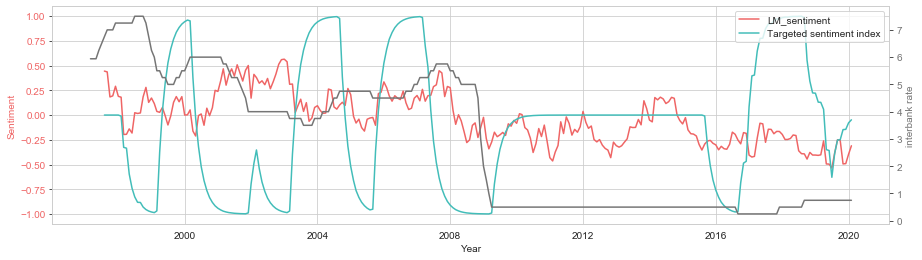

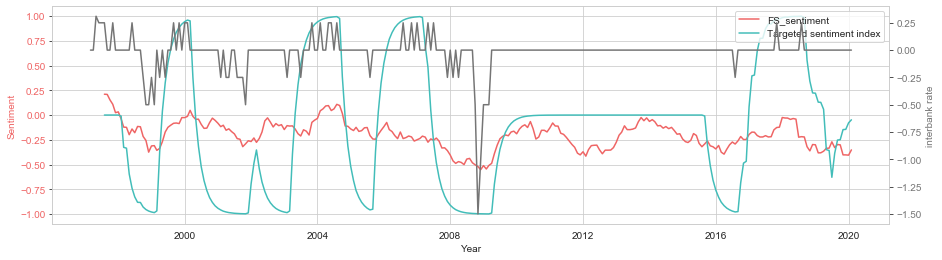

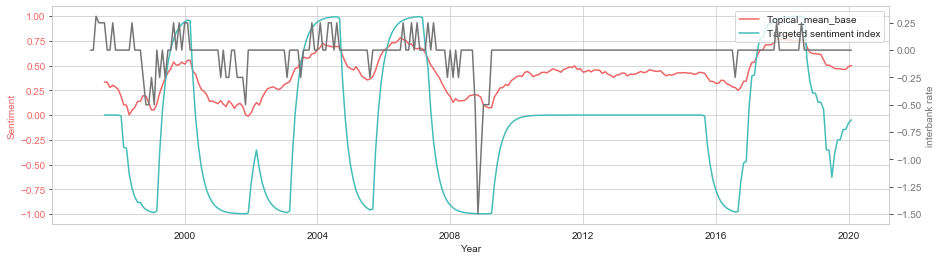

In [756]:
create_comparison_plot(sentiment_97_20,'LM_sentiment',rate = 'Interest_rate')
create_comparison_plot(sentiment_97_20,'FS_sentiment',rate = 'change_of_rate')
create_comparison_plot(sentiment_97_20,'Topical_mean_base',rate = 'change_of_rate')

**Visual word list for each topics**

In [825]:
positive

negative count  postive count  neutral count  p percentage  \
usual                22.0           27.0           14.0      0.428571   
limit                22.0           27.0           29.0      0.346154   
area                 47.0           58.0           29.0      0.432836   
judg                 34.0           42.0           21.0      0.432990   
path                 38.0           47.0           36.0      0.388430   
...                   ...            ...            ...           ...   
refinanc              5.0           17.0            0.0      0.772727   
trough                5.0           17.0            0.0      0.772727   
anchor                7.0           25.0            0.0      0.781250   
primarili             5.0           22.0            7.0      0.647059   
exceed                4.0           20.0           21.0      0.444444   

           n percentage  p percentage no neutral  n percentage no neutral  
usual          0.349206                 0.551020                 0.448980  
limit          0.282051                 0.551020                 0.448980  
area           0.350746                 0.552381                 0.447619  
judg           0.350515                 0.552632                 0.447368  
path           0.314050                 0.552941                 0.447059  
...                 ...                      ...                      ...  
refinanc       0.227273                 0.772727                 0.227273  
trough         0.227273                 0.772727                 0.227273  
anchor         0.218750                 0.781250                 0.218750  
primarili      0.147059                 0.814815                 0.185185  
exceed         0.088889                 0.833333                 0.166667  

[158 rows x 7 columns]

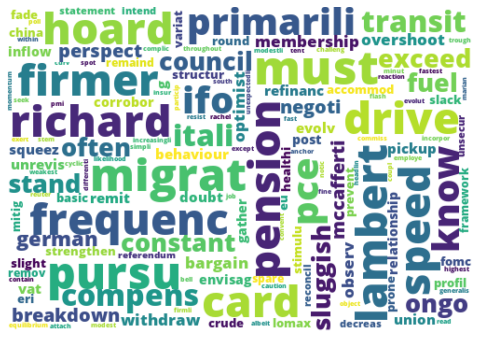

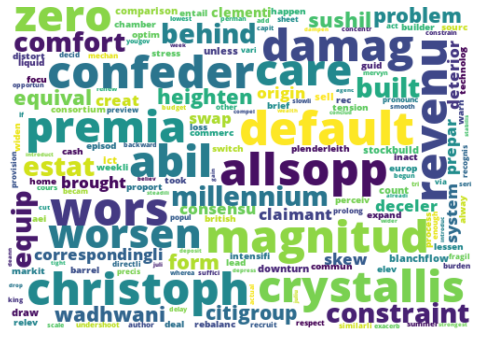

In [801]:
!pip install wordcloud

## Step 2.2 analysis performance accross different time range

Positive count:37   Negative count:53   Neutral count:10
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
Positive count:34   Negative count:58   Neutral count:8
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
calculating all
calculating topic: The immediate policy decision
calculating topic: Money, cr

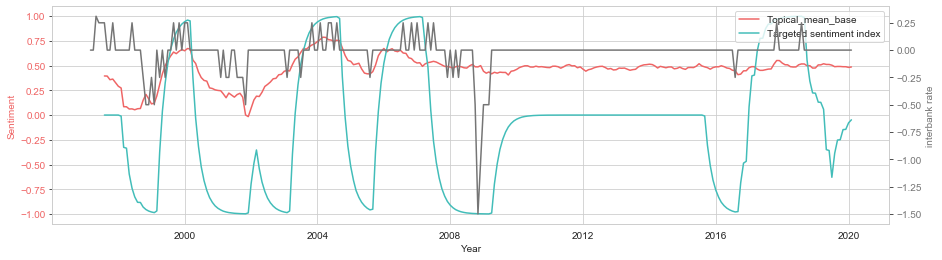

label   label_2  base_all_sentiment  libor_all_sentiment  \
label           1.000000  0.638712            0.468648             0.494101   
label_2         0.638712  1.000000            0.671831             0.369794   
Interest_rate  -0.137836 -0.202106           -0.302007            -0.452590   
change_of_rate  0.242726  0.419701            0.302378             0.096983   

                base_The immediate policy decision_sentiment  \
label                                               0.487121   
label_2                                             0.603643   
Interest_rate                                       0.189778   
change_of_rate                                      0.311232   

                libor_The immediate policy decision_sentiment  \
label                                                0.641031   
label_2                                              0.461913   
Interest_rate                                       -0.136824   
change_of_rate                                       0.172213   

                base_Money, credit, demand and output_sentiment  \
label                                                  0.422647   
label_2                                                0.630734   
Interest_rate                                         -0.050210   
change_of_rate                                         0.259638   

                libor_Money, credit, demand and output_sentiment  \
label                                                   0.540192   
label_2                                                 0.486739   
Interest_rate                                          -0.399572   
change_of_rate                                          0.164426   

                base_Supply, costs and prices_sentiment  \
label                                          0.374326   
label_2                                        0.607605   
Interest_rate                                 -0.548379   
change_of_rate                                 0.232958   

                libor_Supply, costs and prices_sentiment  \
label                                           0.514599   
label_2                                         0.364577   
Interest_rate                                  -0.453476   
change_of_rate                                  0.119009   

                base_The international economy_sentiment  \
label                                           0.439645   
label_2                                         0.600509   
Interest_rate                                  -0.316315   
change_of_rate                                  0.254431   

                libor_The international economy_sentiment  Topical_mean_base  \
label                                            0.489548           0.457522   
label_2                                          0.468888           0.645989   
Interest_rate                                   -0.430598          -0.265944   
change_of_rate                                   0.226511           0.267311   

                Topical_mean_libor  FS_sentiment  LM_sentiment  Interest_rate  \
label                     0.548437      0.399016      0.066243      -0.137836   
label_2                   0.450723      0.399228     -0.139119      -0.202106   
Interest_rate            -0.456285      0.245016      0.641400       1.000000   
change_of_rate            0.125873      0.408340     -0.027290      -0.054722   

                change_of_rate  
label                 0.242726  
label_2               0.419701  
Interest_rate        -0.054722  
change_of_rate        1.000000

In [785]:
end_date, start_date='2005-12-31','1997-08-01'
interested_topics =['The immediate policy decision','Money, credit, demand and output','Supply, costs and prices','The international economy']

training_data = minutes_timeseries.loc[end_date:start_date]
word_document_frequency_97_05,dictionary_model_97_05 = training_dictionary_sentiment(training_data,para_set=[[10,0.55,0.6],[5,0.55,0.6]])
sentiment_97_05 = result_dictionary_sentiment(dictionary_model_97_05,interested_topics)
create_comparison_plot(sentiment_97_05,'Topical_mean_base',rate = 'change_of_rate')
sentiment_97_05.corr().iloc[[0,1,16,17],:]

In [ ]:
end_date, start_date='2010-12-31','1997-08-01'
interested_topics =['The immediate policy decision','Money, credit, demand and output','Supply, costs and prices','The international economy']

training_data = minutes_timeseries.loc[end_date:start_date]
word_document_frequency_97_11,dictionary_model_97_11 = training_dictionary_sentiment(training_data,para_set=[[16,0.55,0.6],[8,0.55,0.6]])
sentiment_97_11 = result_dictionary_sentiment(dictionary_model_97_11,interested_topics)



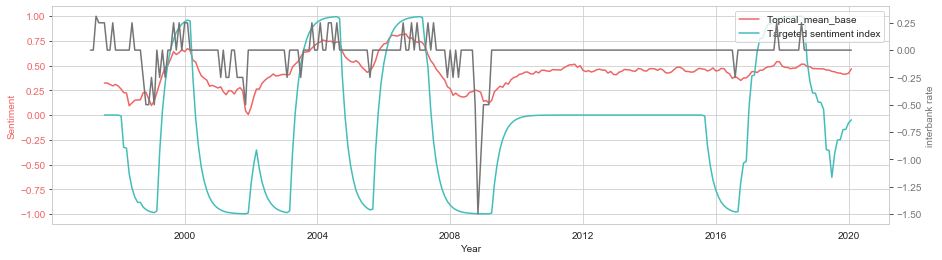

label   label_2  base_all_sentiment  libor_all_sentiment  \
label           1.000000  0.638712            0.566772             0.585617   
label_2         0.638712  1.000000            0.716198             0.545690   
Interest_rate  -0.137836 -0.202106            0.007564            -0.719817   
change_of_rate  0.242726  0.419701            0.423044             0.291542   

                base_The immediate policy decision_sentiment  \
label                                               0.554497   
label_2                                             0.752294   
Interest_rate                                       0.003797   
change_of_rate                                      0.449514   

                libor_The immediate policy decision_sentiment  \
label                                                0.596080   
label_2                                              0.530556   
Interest_rate                                       -0.718606   
change_of_rate                                       0.280502   

                base_Money, credit, demand and output_sentiment  \
label                                                  0.525876   
label_2                                                0.756817   
Interest_rate                                          0.200595   
change_of_rate                                         0.393702   

                libor_Money, credit, demand and output_sentiment  \
label                                                   0.667108   
label_2                                                 0.535649   
Interest_rate                                          -0.581336   
change_of_rate                                          0.248693   

                base_Supply, costs and prices_sentiment  \
label                                          0.446588   
label_2                                        0.706391   
Interest_rate                                 -0.115580   
change_of_rate                                 0.426405   

                libor_Supply, costs and prices_sentiment  \
label                                           0.507316   
label_2                                         0.429912   
Interest_rate                                  -0.711521   
change_of_rate                                  0.189015   

                base_The international economy_sentiment  \
label                                           0.539610   
label_2                                         0.735001   
Interest_rate                                  -0.097752   
change_of_rate                                  0.399876   

                libor_The international economy_sentiment  Topical_mean_base  \
label                                            0.692815           0.543484   
label_2                                          0.609902           0.776324   
Interest_rate                                   -0.423765          -0.103811   
change_of_rate                                   0.354948           0.418696   

                Topical_mean_libor  FS_sentiment  LM_sentiment  Interest_rate  \
label                     0.592637      0.399016      0.066243      -0.137836   
label_2                   0.521851      0.399228     -0.139119      -0.202106   
Interest_rate            -0.712278      0.245016      0.641400       1.000000   
change_of_rate            0.233010      0.408340     -0.027290      -0.054722   

                change_of_rate  
label                 0.242726  
label_2               0.419701  
Interest_rate        -0.054722  
change_of_rate        1.000000

In [788]:
create_comparison_plot(sentiment_97_11,'Topical_mean_base',rate = 'change_of_rate')
sentiment_97_11.corr().iloc[[0,1,16,17],:]

In [844]:
word_document_frequency_97_11[0]['All'].sort_values(by='p percentage no neutral',ascending=False)

negative count  postive count  neutral count  p percentage  \
subtract             0.0            5.0            6.0      0.454545   
arithmet             0.0            1.0           12.0      0.076923   
ppiy                 0.0            2.0           12.0      0.142857   
overlap              0.0           13.0            0.0      1.000000   
firmer               1.0           10.0            6.0      0.588235   
...                  ...            ...            ...           ...   
iii                  0.0            0.0           12.0      0.000000   
jobseek              0.0            0.0           18.0      0.000000   
jsa                  0.0            0.0           12.0      0.000000   
predomin             0.0            0.0           12.0      0.000000   
recipi               0.0            0.0           12.0      0.000000   

          n percentage  p percentage no neutral  n percentage no neutral  
subtract      0.000000                 1.000000                 0.000000  
arithmet      0.000000                 1.000000                 0.000000  
ppiy          0.000000                 1.000000                 0.000000  
overlap       0.000000                 1.000000                 0.000000  
firmer        0.058824                 0.909091                 0.090909  
...                ...                      ...                      ...  
iii           0.000000                      NaN                      NaN  
jobseek       0.000000                      NaN                      NaN  
jsa           0.000000                      NaN                      NaN  
predomin      0.000000                      NaN                      NaN  
recipi        0.000000                      NaN                      NaN  

[1816 rows x 7 columns]